In [3]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from batman import TransitParams, TransitModel
import astropy.units as u
from astropy.io import fits
from glob import glob

In [4]:
paths = glob('/Users/bmmorris/data/hat11/*slc.fits')

times = []
fluxes = []

for path in paths: 
    f = fits.getdata(path)
    times.append(f['TIME'])
    fluxes.append(f['PDCSAP_FLUX'] / np.nanmedian(f['PDCSAP_FLUX']))
    
times = np.concatenate(times)
fluxes = np.concatenate(fluxes)

In [5]:
fluxes = fluxes[~np.isnan(times)]
times = times[~np.isnan(times)] + 2454833

In [6]:
import sys
sys.path.insert(0, '/Users/bmmorris/git/TESSellate/')
from toolkit import LightCurve
from astropy.time import Time

In [7]:
params = TransitParams()
params.per = 4.8878025843894006
params.t0 = 2454605.8914623754
params.duration = 0.097973065981468405
params.a = 14.770858177139598
params.b = 0.143443142704645
params.ecc = 0.274492258542932
params.inc_stellar = 80
params.rho_star = 1.8082748494218275
params.limb_dark = "quadratic"
params.per = 4.8878025843894006
params.per_rot = 29.192083459347486 
params.lam = 106.0
params.w = 18.03890135536712
params.rp = 0.058330305324663184
params.u = [
        0.6407001070602456, 
        0.047761746059854178
    ]
params.inc = 89.34708509841991
        
lc = LightCurve(Time(times, format='jd'), fluxes)

In [22]:
residual = []

transits = LightCurve(**lc.mask_out_of_transit(params, oot_duration_fraction=1)).get_transit_light_curves(params)

for transit in transits: 
    transit.remove_polynomial_baseline(params, order=1)
    
    transit.fluxes /= TransitModel(params, transit.times.jd).light_curve(params)
    if np.count_nonzero(transit.fluxes - 1 > 4 * np.std(transit.fluxes)) > 1:
        residual.append(transit.fluxes.max() - 1)
#         transit.plot()
    else: 
        residual.append(0)


/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


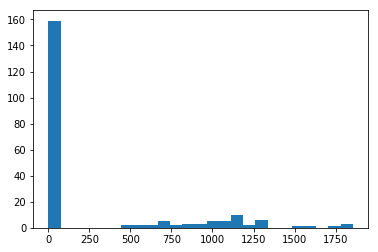

In [24]:
np.save('data/hat11_residuals.npy', residual)
plt.hist(np.array(residual) * 1e6, 25);